In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy import optimize
from torch.autograd import grad
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d

In [2]:
class PINN_sys(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN_sys, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, output_size), nn.Tanh()
        )
        self.params = nn.Parameter(torch.rand(3))  # Learnable parameters

    def forward(self, x):
        return self.net(x)

# Training function
def train_pinn_sys(model, 
                   t_train, 
                   G1_data,
                   G2_data,
                   P_data,
                   D_data,
                   zero_init,
                   known_param,
                   num_epochs, 
                   learning_rate
                   ):
    
    # Define the loss function (MSE for the PINN)
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.5, verbose=True)
    
    # write the loss and params to a list
    epoch_list = []
    loss_list = []
    fg_list = []
    fm_list = []
    fp_list = []

    # Training loop
    for epoch in range(num_epochs):
        # Convert to PyTorch tensors
        t_train = torch.FloatTensor(t_train.reshape(-1, 1))
        G1_tensor = torch.FloatTensor(G1_data.reshape(-1, 1))
        G2_tensor = torch.FloatTensor(G2_data.reshape(-1, 1))
        P_tensor = torch.FloatTensor(P_data.reshape(-1, 1))
        D_tensor = torch.FloatTensor(D_data.reshape(-1, 1))
        zero_init = torch.FloatTensor(zero_init.reshape(-1, 1))
        known_param = torch.FloatTensor(known_param.reshape(-1, 1))
        
        t_train.requires_grad_()

        # Forward pass
        NN = model(t_train)
        G1, G2, P, D = torch.split(NN, 1, dim=1)
        
        G1_ones = torch.ones_like(G1)
        G2_ones = torch.ones_like(G2)
        P_ones = torch.ones_like(P)
        D_ones = torch.ones_like(D)

        # Compute the gradients of the variables
        G1_t = grad(G1, t_train, G1_ones, create_graph=True)[0]
        G2_t = grad(G2, t_train, G2_ones, create_graph=True)[0]
        P_t = grad(P, t_train, P_ones, create_graph=True)[0]
        D_t = grad(D, t_train, D_ones, create_graph=True)[0]
        
        # ensure the model parameters are positive
        param_reg = torch.abs(model.params)
        fg = param_reg[0]
        fm = param_reg[1]
        fp = param_reg[2]
        
        k1 = known_param[0]
        k2 = known_param[1]
        k3 = known_param[2]
        kd = known_param[3]
        kd2 = known_param[4]
        cGEM = known_param[5]
        
        # residual loss
        l1 = criterion(G1_t, -k1*(1-fg)*G1 + 2*k2*(1-fm)*G2 - kd*G1)
        l2 = criterion(G2_t, k1*(1-fg)*G1 - k2*(1-fm)*G2 - k3*(1-fp)*G2 - kd*cGEM*G2)
        l3 = criterion(P_t, k3*(1-fp)*G2 - kd2*P)
        l4 = criterion(D_t, kd*G1 + kd*cGEM*G2 + kd2*P)
        
        # data loss
        sum_loss1 = criterion(G1, G1_tensor)
        sum_loss2 = criterion(G2, G2_tensor)
        sum_loss3 = criterion(P, P_tensor)
        sum_loss4 = criterion(D, D_tensor)
        
        # initial conditions loss
        G1_init_loss = criterion(G1[0], zero_init[0])
        G2_init_loss = criterion(G2[0], zero_init[1])
        P_init_loss = criterion(P[0], zero_init[2])
        D_init_loss = criterion(D[0], zero_init[3])
        
       
        # residual loss + data loss + initial conditions loss 
        total_loss = (l1 + l2 + l3 + l4 + \
                      sum_loss1 + sum_loss2 + sum_loss3 + sum_loss4 +  \
                      G1_init_loss + G2_init_loss + P_init_loss + D_init_loss)       

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Update the learning rate based on the validation loss
        scheduler.step(total_loss)
        
        # Print progress
        if (epoch + 1) % 200 == 0:
            loss_item = round(total_loss.item(), 4)
            param_item = param_reg.data.numpy()
            epoch_list.append(epoch+1)
            loss_list.append(loss_item)
            fg_list.append(param_item[0])
            fm_list.append(param_item[1])
            fp_list.append(param_item[2])
            print(f'Epoch [{epoch+1}/{num_epochs}]', 
                  f'Loss: {total_loss.item():.2e}', 
                  f'params: {param_reg.data.numpy()}')
            
        # save list containing loss and params to csv files
        loss_param_df = pd.DataFrame(data={"Num Epoch": epoch_list,
                                           "loss": loss_list,
                                           "fg": fg_list,
                                           "fm": fm_list,
                                           "fp": fp_list
                                           })
        loss_param_df.to_csv("./loss_param_1c.csv", sep=',',index=False)

    print('Training completed.')

In [3]:
t = np.linspace(2,39,38)

print(t)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39.]


In [4]:

def drug_dose_param(file,known_param,t):
    #file = pd.read_csv('filename')
    
    file_D = file.iloc[0,:-1].to_numpy()
    file_G1 = file.iloc[1,:-1].to_numpy()
    file_G2 = file.iloc[2,:-1].to_numpy()
    file_P = file.iloc[3,:-1].to_numpy()
    
    # scaling the data
    max_file_G1 = np.max(file_G1)
    max_file_G2 = np.max(file_G2)
    max_file_P = np.max(file_P)
    max_file_D = np.max(file_D)
    
    max_file = np.max([max_file_G1, max_file_G2, max_file_P, max_file_D])
    ###########################################################################
    
    t_train = t
    file_G1_data = file_G1 / max_file
    file_G2_data = file_G2 / max_file
    file_P_data = file_P / max_file
    file_D_data = file_D / max_file
    
    # Set initial conditions for all variables
    file_zero_init = np.array([file_G1_data[0], file_G2_data[0], file_P_data[0], file_D_data[0]])
    
    # Create and train the PINN model
    input_size = 1; hidden_size = 32; output_size = 4; num_epochs =  6000; learning_rate = 1e-3
    
    model = PINN_sys(input_size, hidden_size, output_size)
    train_pinn_sys(model,
                   t_train, file_G1_data, file_G2_data, file_P_data,
                   file_D_data, file_zero_init, known_param, num_epochs, learning_rate)
    
    # Test the trained model
    t_test = t
    t_test = torch.FloatTensor(t_test.reshape(-1, 1))
    file_pred = model(t_test).detach().numpy()
    
    file_G1_pred = file_pred[:, 0] * max_file
    file_G2_pred = file_pred[:, 1] * max_file
    file_P_pred = file_pred[:, 2] * max_file
    file_D_pred = file_pred[:, 3] * max_file
    
    return file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred


In [5]:
cGEM_all = np.array([0, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800])

kn_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656])
kn_param_4N = np.array([0.04754016, 1.06978193, 0.02534762, 0.00800557, 0.00394785])

In [6]:
# GEM 2N
# A_3, cGEM=3.125

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 3.125])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_3.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 8.45e-03 params: [0.03093755 0.20537752 0.5282054 ]
Epoch [400/6000] Loss: 4.84e-03 params: [2.8183684e-05 4.0129226e-01 7.2683585e-01]
Epoch [600/6000] Loss: 4.16e-03 params: [4.3646332e-07 5.1755595e-01 8.5364008e-01]
Epoch 00649: reducing learning rate of group 0 to 5.0000e-04.
Epoch [800/6000] Loss: 4.02e-03 params: [0.00981871 0.54702085 0.893408  ]
Epoch [1000/6000] Loss: 3.88e-03 params: [0.03287798 0.56139594 0.91976   ]
Epoch [1200/6000] Loss: 3.75e-03 params: [0.06410462 0.5746554  0.9501406 ]
Epoch [1400/6000] Loss: 3.63e-03 params: [0.10155251 0.589183   0.98795784]
Epoch [1600/6000] Loss: 3.53e-03 params: [0.14474168 0.60559857 1.0344056 ]
Epoch [1800/6000] Loss: 3.43e-03 params: [0.19375919 0.6240503  1.0896554 ]
Epoch [2000/6000] Loss: 3.34e-03 params: [0.24855456 0.6445395  1.153415  ]
Epoch [2200/6000] Loss: 3.62e-03 params: [0.30882907 0.6670125  1.2251472 ]
Epoch [2400/6000] Loss: 3.17e-03 params: [0.37425253 0.6911167  1.3041307 ]
Epoch [2600/

In [8]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.1131539
fm=0.9437791
fp=2.3675585


In [9]:
# GEM 2N
# B_3, cGEM=3.125

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 3.125])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_3.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 6.40e-03 params: [0.04969702 0.39510772 0.93759817]
Epoch [400/6000] Loss: 3.39e-03 params: [3.1594345e-06 4.4531733e-01 1.0181094e+00]
Epoch [600/6000] Loss: 2.93e-03 params: [1.3170328e-05 4.5039997e-01 1.0603565e+00]
Epoch [800/6000] Loss: 2.70e-03 params: [8.9328423e-06 4.4737911e-01 1.0936056e+00]
Epoch 00923: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1000/6000] Loss: 2.58e-03 params: [4.0574432e-06 4.4466433e-01 1.1170423e+00]
Epoch [1200/6000] Loss: 2.48e-03 params: [9.5550777e-06 4.4285902e-01 1.1301521e+00]
Epoch [1400/6000] Loss: 2.38e-03 params: [1.5437130e-05 4.4097072e-01 1.1424035e+00]
Epoch [1600/6000] Loss: 2.29e-03 params: [1.9130648e-05 4.3930656e-01 1.1534941e+00]
Epoch [1800/6000] Loss: 2.23e-03 params: [5.2211171e-06 4.3810454e-01 1.1632096e+00]
Epoch [2000/6000] Loss: 2.19e-03 params: [4.1340783e-05 4.3712175e-01 1.1712940e+00]
Epoch [2200/6000] Loss: 2.28e-03 params: [1.0170250e-04 4.3621662e-01 1.1778432e+00]
Epoch 02221: red

In [10]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.011913e-05
fm=0.43780208
fp=1.2736831


In [11]:
# GEM 2N
# C_3, cGEM=3.125

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 3.125])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_3.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 9.50e-03 params: [0.3630737  0.28052145 0.43820798]
Epoch [400/6000] Loss: 4.76e-03 params: [0.21936528 0.4157651  0.6168723 ]
Epoch [600/6000] Loss: 4.19e-03 params: [0.1434845 0.5092325 0.7659647]
Epoch [800/6000] Loss: 4.05e-03 params: [0.13178627 0.5478024  0.8815972 ]
Epoch [1000/6000] Loss: 3.71e-03 params: [0.15141067 0.5633621  0.9857707 ]
Epoch [1200/6000] Loss: 3.59e-03 params: [0.18363847 0.5760376  1.0909581 ]
Epoch [1400/6000] Loss: 3.48e-03 params: [0.22360004 0.58939075 1.1996249 ]
Epoch [1600/6000] Loss: 3.37e-03 params: [0.26837406 0.60444903 1.3123947 ]
Epoch [1800/6000] Loss: 3.29e-03 params: [0.31674916 0.62061155 1.4289838 ]
Epoch [2000/6000] Loss: 3.20e-03 params: [0.36733714 0.6370172  1.5477507 ]
Epoch [2200/6000] Loss: 3.13e-03 params: [0.41797695 0.6528426  1.6663611 ]
Epoch [2400/6000] Loss: 3.08e-03 params: [0.4666333 0.6669031 1.7819306]
Epoch [2600/6000] Loss: 3.03e-03 params: [0.5111994 0.6798583 1.8920488]
Epoch [2800/6000] Loss: 3

In [12]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.73131996
fm=0.76392233
fp=2.359938


In [13]:
# GEM 2N
# D_3, cGEM=3.125

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 3.125])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_3.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 8.17e-03 params: [0.5561322  0.27917406 0.7729857 ]
Epoch [400/6000] Loss: 3.33e-03 params: [0.42431924 0.39610144 0.95435196]
Epoch [600/6000] Loss: 2.81e-03 params: [0.35980263 0.4371681  1.0926276 ]
Epoch 00775: reducing learning rate of group 0 to 5.0000e-04.
Epoch [800/6000] Loss: 2.44e-03 params: [0.32978535 0.4327691  1.1974884 ]
Epoch [1000/6000] Loss: 2.31e-03 params: [0.31619447 0.42496884 1.24963   ]
Epoch [1200/6000] Loss: 2.20e-03 params: [0.3022287  0.41562095 1.300841  ]
Epoch [1400/6000] Loss: 2.11e-03 params: [0.28768536 0.40586862 1.3500268 ]
Epoch [1600/6000] Loss: 2.07e-03 params: [0.2729626 0.3964494 1.3961803]
Epoch [1800/6000] Loss: 3.14e-03 params: [0.2585274  0.38785413 1.4384629 ]
Epoch [2000/6000] Loss: 1.95e-03 params: [0.24513632 0.38040462 1.4763112 ]
Epoch 02070: reducing learning rate of group 0 to 2.5000e-04.
Epoch [2200/6000] Loss: 1.93e-03 params: [0.23699684 0.37626386 1.4994624 ]
Epoch [2400/6000] Loss: 1.91e-03 params: [0.231

In [14]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.23360129
fm=0.37445915
fp=1.7241403


In [15]:
# GEM 2N
# A_4, cGEM=6.25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 6.25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_4.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.28e-02 params: [0.46139723 0.8991579  1.071198  ]
Epoch [400/6000] Loss: 7.78e-03 params: [0.368236  0.8787292 1.2634718]
Epoch [600/6000] Loss: 6.81e-03 params: [0.25939497 0.85534406 1.4279714 ]
Epoch [800/6000] Loss: 6.56e-03 params: [0.15378448 0.83442175 1.5575273 ]
Epoch [1000/6000] Loss: 6.16e-03 params: [0.06041493 0.817208   1.6533712 ]
Epoch [1200/6000] Loss: 6.02e-03 params: [3.9851991e-05 8.0502665e-01 1.7180035e+00]
Epoch [1400/6000] Loss: 5.93e-03 params: [3.3850225e-05 8.0378509e-01 1.7666703e+00]
Epoch [1600/6000] Loss: 7.69e-03 params: [1.5240337e-05 8.0228639e-01 1.8044522e+00]
Epoch [1800/6000] Loss: 5.79e-03 params: [2.5471043e-05 8.0161101e-01 1.8323135e+00]
Epoch 01912: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2000/6000] Loss: 5.76e-03 params: [5.4331736e-05 8.0144000e-01 1.8486247e+00]
Epoch [2200/6000] Loss: 5.73e-03 params: [6.9901922e-05 8.0110610e-01 1.8573673e+00]
Epoch [2400/6000] Loss: 5.70e-03 params: [3.6662466e-05

In [16]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=2.333973e-05
fm=0.8074494
fp=2.0306816


In [17]:
# GEM 2N
# B_4, cGEM=6.25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 6.25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_4.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.81e-02 params: [5.5527860e-05 8.0141133e-01 9.7534233e-01]
Epoch [400/6000] Loss: 9.83e-03 params: [2.2734668e-05 8.4734988e-01 1.1487929e+00]
Epoch [600/6000] Loss: 7.39e-03 params: [2.7677908e-05 8.3955842e-01 1.3021915e+00]
Epoch [800/6000] Loss: 6.58e-03 params: [3.0039271e-05 8.3308357e-01 1.4449065e+00]
Epoch [1000/6000] Loss: 6.08e-03 params: [3.9510694e-05 8.2903087e-01 1.5740237e+00]
Epoch [1200/6000] Loss: 8.98e-03 params: [2.5127118e-05 8.2551032e-01 1.6878364e+00]
Epoch 01240: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1400/6000] Loss: 5.72e-03 params: [2.1763681e-05 8.2411140e-01 1.7488703e+00]
Epoch [1600/6000] Loss: 5.61e-03 params: [3.6666752e-05 8.2244635e-01 1.7974147e+00]
Epoch [1800/6000] Loss: 5.52e-03 params: [4.5474695e-05 8.2095683e-01 1.8434026e+00]
Epoch [2000/6000] Loss: 5.45e-03 params: [3.8790549e-05 8.1961024e-01 1.8861654e+00]
Epoch [2200/6000] Loss: 5.50e-03 params: [2.7448532e-05 8.1840265e-01 1.9251293e+00]
Epoch 0

In [18]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.0746952e-05
fm=0.81360054
fp=2.0993881


In [19]:
# GEM 2N
# C_4, cGEM=6.25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 6.25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_4.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 2.46e-02 params: [0.5596991 0.725065  1.0454592]
Epoch [400/6000] Loss: 8.82e-03 params: [0.4211323 0.865681  1.2326629]
Epoch [600/6000] Loss: 7.51e-03 params: [0.35667208 0.9104649  1.366025  ]
Epoch 00773: reducing learning rate of group 0 to 5.0000e-04.
Epoch [800/6000] Loss: 7.09e-03 params: [0.32102287 0.91383994 1.4708819 ]
Epoch [1000/6000] Loss: 6.95e-03 params: [0.30226794 0.911648   1.525964  ]
Epoch [1200/6000] Loss: 6.84e-03 params: [0.28158012 0.9084455  1.5819436 ]
Epoch [1400/6000] Loss: 6.76e-03 params: [0.2586184 0.9049417 1.6377436]
Epoch [1600/6000] Loss: 6.69e-03 params: [0.23337631 0.90133166 1.6923376 ]
Epoch [1800/6000] Loss: 6.63e-03 params: [0.20593537 0.8977424  1.7447525 ]
Epoch 01983: reducing learning rate of group 0 to 2.5000e-04.
Epoch [2000/6000] Loss: 6.59e-03 params: [0.17768897 0.8941919  1.7922704 ]
Epoch [2200/6000] Loss: 6.55e-03 params: [0.16176198 0.8923284  1.81622   ]
Epoch [2400/6000] Loss: 6.53e-03 params: [0.14457555 

In [20]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.9328287e-05
fm=0.87208277
fp=2.0659506


In [21]:
# GEM 2N
# D_4, cGEM=6.25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 6.25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_4.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.49e-02 params: [0.17585187 0.8072099  0.55448854]
Epoch [400/6000] Loss: 5.29e-03 params: [0.07713408 0.7584627  0.7639463 ]
Epoch [600/6000] Loss: 4.05e-03 params: [1.1148560e-04 7.2965145e-01 9.5220393e-01]
Epoch [800/6000] Loss: 4.82e-03 params: [4.5064990e-06 7.2389954e-01 1.1247835e+00]
Epoch [1000/6000] Loss: 3.35e-03 params: [1.20069235e-05 7.20419526e-01 1.28268766e+00]
Epoch 01176: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1200/6000] Loss: 3.22e-03 params: [1.7813723e-05 7.1719217e-01 1.4182633e+00]
Epoch [1400/6000] Loss: 3.14e-03 params: [1.8161098e-05 7.1505380e-01 1.4862056e+00]
Epoch [1600/6000] Loss: 3.08e-03 params: [1.8634337e-05 7.1320921e-01 1.5526733e+00]
Epoch [1800/6000] Loss: 3.03e-03 params: [1.8978224e-05 7.1152723e-01 1.6170425e+00]
Epoch [2000/6000] Loss: 2.99e-03 params: [1.9228224e-05 7.0998639e-01 1.6788336e+00]
Epoch [2200/6000] Loss: 2.98e-03 params: [3.2631295e-05 7.0844018e-01 1.7375997e+00]
Epoch 02216: reducing 

In [22]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.0087875e-05
fm=0.7015634
fp=2.0993211


In [23]:
# GEM 2N
# A_5, cGEM=12.5

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 12.5])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_5.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 7.72e-02 params: [0.39778936 0.4331471  0.9557597 ]
Epoch [400/6000] Loss: 4.84e-02 params: [0.20636007 0.659946   1.1866872 ]
Epoch [600/6000] Loss: 2.46e-02 params: [0.08185443 0.84318143 1.3926628 ]
Epoch [800/6000] Loss: 1.73e-02 params: [0.0443233 0.9278079 1.5305123]
Epoch [1000/6000] Loss: 1.58e-02 params: [0.0548047  0.95144874 1.625495  ]
Epoch [1200/6000] Loss: 1.48e-02 params: [0.08181296 0.9580673  1.7077786 ]
Epoch [1400/6000] Loss: 1.36e-02 params: [0.11558408 0.9618856  1.7864555 ]
Epoch [1600/6000] Loss: 1.26e-02 params: [0.1533847  0.96560353 1.8626809 ]
Epoch [1800/6000] Loss: 1.22e-02 params: [0.19416791 0.96941644 1.9346372 ]
Epoch [2000/6000] Loss: 1.20e-02 params: [0.23799644 0.9730892  2.0001972 ]
Epoch [2200/6000] Loss: 1.19e-02 params: [0.2841931 0.9765648 2.0588398]
Epoch [2400/6000] Loss: 1.18e-02 params: [0.3317892 0.9800007 2.1107104]
Epoch [2600/6000] Loss: 1.17e-02 params: [0.38000605 0.98337525 2.1561327 ]
Epoch [2800/6000] Loss: 1

In [24]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.76116383
fm=1.0112497
fp=2.3978627


In [25]:
# GEM 2N
# B_5, cGEM=12.5

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 12.5])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_5.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.21e-02 params: [0.62650436 0.9360577  0.7517732 ]
Epoch [400/6000] Loss: 2.30e-02 params: [0.53611654 1.0165156  0.9098535 ]
Epoch [600/6000] Loss: 1.57e-02 params: [0.50748646 1.0265394  1.0503712 ]
Epoch [800/6000] Loss: 1.46e-02 params: [0.49121773 1.0240817  1.1877354 ]
Epoch [1000/6000] Loss: 1.38e-02 params: [0.4768379 1.0214692 1.3209949]
Epoch [1200/6000] Loss: 1.31e-02 params: [0.4643745 1.0189342 1.4484941]
Epoch [1400/6000] Loss: 1.27e-02 params: [0.45414302 1.0167451  1.5689822 ]
Epoch [1600/6000] Loss: 1.25e-02 params: [0.44717327 1.0148127  1.680644  ]
Epoch [1800/6000] Loss: 1.23e-02 params: [0.44444075 1.013001   1.7817459 ]
Epoch [2000/6000] Loss: 1.22e-02 params: [0.44594136 1.011587   1.8716297 ]
Epoch [2200/6000] Loss: 1.21e-02 params: [0.45136434 1.0106064  1.9501821 ]
Epoch [2400/6000] Loss: 1.21e-02 params: [0.4601047 1.0100389 2.017673 ]
Epoch [2600/6000] Loss: 1.22e-02 params: [0.47144052 1.009774   2.0745301 ]
Epoch 02638: reducing lea

In [26]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.56980366
fm=1.0123497
fp=2.257992


In [27]:
# GEM 2N
# C_5, cGEM=12.5

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 12.5])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_5.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 9.35e-02 params: [0.25793162 0.5840618  0.67671365]
Epoch [400/6000] Loss: 4.48e-02 params: [0.08041872 0.79319257 0.9043353 ]
Epoch [600/6000] Loss: 2.54e-02 params: [2.0586331e-04 9.2651927e-01 1.0921046e+00]
Epoch [800/6000] Loss: 2.18e-02 params: [7.3401643e-06 9.7633547e-01 1.2344171e+00]
Epoch [1000/6000] Loss: 2.06e-02 params: [7.6968599e-06 9.8751760e-01 1.3568411e+00]
Epoch [1200/6000] Loss: 1.94e-02 params: [1.4513485e-06 9.8784041e-01 1.4730966e+00]
Epoch [1400/6000] Loss: 1.78e-02 params: [2.5204581e-06 9.8588467e-01 1.5870354e+00]
Epoch [1600/6000] Loss: 1.70e-02 params: [3.3893348e-06 9.8403037e-01 1.6990211e+00]
Epoch [1800/6000] Loss: 1.65e-02 params: [8.836345e-06 9.826602e-01 1.805774e+00]
Epoch [2000/6000] Loss: 1.62e-02 params: [8.8769921e-06 9.8127824e-01 1.9051068e+00]
Epoch [2200/6000] Loss: 1.60e-02 params: [4.6876103e-06 9.7995722e-01 1.9955913e+00]
Epoch [2400/6000] Loss: 1.59e-02 params: [4.7657350e-06 9.7874528e-01 2.0761266e+00]
Epoch

In [28]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=6.9864677e-06
fm=0.9740437
fp=2.3772602


In [29]:
# GEM 2N
# D_5, cGEM=12.5

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 12.5])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_5.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.29e-01 params: [0.4866544 0.3590404 0.797906 ]
Epoch [400/6000] Loss: 8.07e-02 params: [0.2836509 0.5990944 1.0416037]
Epoch [600/6000] Loss: 3.96e-02 params: [0.12775575 0.81144446 1.2733322 ]
Epoch [800/6000] Loss: 2.41e-02 params: [0.04681785 0.9317394  1.4384093 ]
Epoch [1000/6000] Loss: 2.00e-02 params: [0.01969562 0.9721852  1.5463214 ]
Epoch [1200/6000] Loss: 1.78e-02 params: [0.01303231 0.9824783  1.6342595 ]
Epoch [1400/6000] Loss: 1.72e-02 params: [0.01362044 0.9853396  1.7151985 ]
Epoch [1600/6000] Loss: 1.68e-02 params: [0.01807988 0.98550576 1.7884793 ]
Epoch [1800/6000] Loss: 1.66e-02 params: [0.0247636 0.9851357 1.8543482]
Epoch [2000/6000] Loss: 1.64e-02 params: [0.03322333 0.9848566  1.9125595 ]
Epoch [2200/6000] Loss: 1.62e-02 params: [0.04336953 0.9847816  1.9629234 ]
Epoch [2400/6000] Loss: 1.61e-02 params: [0.05516261 0.9848972  2.005465  ]
Epoch [2600/6000] Loss: 1.59e-02 params: [0.06845497 0.9853527  2.0406475 ]
Epoch [2800/6000] Loss: 1

In [30]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.2664721
fm=0.9978474
fp=2.1774185


In [31]:
# GEM 2N
# A_6, cGEM=25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_6.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.60e-02 params: [0.3090364 0.88425   0.376065 ]
Epoch [400/6000] Loss: 2.86e-02 params: [0.2009408  1.0190747  0.58345455]
Epoch [600/6000] Loss: 2.43e-02 params: [0.18398681 1.0615287  0.7729264 ]
Epoch [800/6000] Loss: 2.34e-02 params: [0.20420808 1.0679985  0.95073235]
Epoch [1000/6000] Loss: 2.28e-02 params: [0.23401646 1.0689396  1.1243774 ]
Epoch [1200/6000] Loss: 2.20e-02 params: [0.2680423 1.0697316 1.2945166]
Epoch [1400/6000] Loss: 2.15e-02 params: [0.3050404 1.0708919 1.4608335]
Epoch [1600/6000] Loss: 2.11e-02 params: [0.34412017 1.0723326  1.6230348 ]
Epoch [1800/6000] Loss: 2.03e-02 params: [0.38444683 1.073926   1.780792  ]
Epoch [2000/6000] Loss: 1.99e-02 params: [0.42522115 1.075642   1.9338374 ]
Epoch [2200/6000] Loss: 1.94e-02 params: [0.46556067 1.0773742  2.081888  ]
Epoch [2400/6000] Loss: 1.90e-02 params: [0.5044249 1.0788277 2.2246606]
Epoch [2600/6000] Loss: 1.87e-02 params: [0.5408549 1.080109  2.3619273]
Epoch [2800/6000] Loss: 1.85e-0

In [32]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.75329965
fm=1.0807875
fp=3.4738712


In [33]:
# GEM 2N
# B_6, cGEM=25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_6.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.48e-02 params: [0.65755016 0.9459417  0.9601673 ]
Epoch [400/6000] Loss: 2.79e-02 params: [0.5274755 1.0451844 1.1506315]
Epoch [600/6000] Loss: 2.20e-02 params: [0.4685985 1.077707  1.3304292]
Epoch [800/6000] Loss: 2.04e-02 params: [0.4324136 1.077369  1.5008518]
Epoch [1000/6000] Loss: 2.05e-02 params: [0.3979582 1.0728002 1.6668648]
Epoch [1200/6000] Loss: 1.85e-02 params: [0.36326692 1.0678158  1.8282812 ]
Epoch [1400/6000] Loss: 1.77e-02 params: [0.3299644 1.0634017 1.9847986]
Epoch [1600/6000] Loss: 1.73e-02 params: [0.3005967 1.0592148 2.1353161]
Epoch [1800/6000] Loss: 1.70e-02 params: [0.27677974 1.0553031  2.2785215 ]
Epoch [2000/6000] Loss: 1.67e-02 params: [0.2589228 1.0519637 2.414299 ]
Epoch [2200/6000] Loss: 1.90e-02 params: [0.24752717 1.0492272  2.5422342 ]
Epoch [2400/6000] Loss: 1.62e-02 params: [0.24272594 1.0470241  2.6624649 ]
Epoch [2600/6000] Loss: 1.61e-02 params: [0.24440734 1.0454718  2.774774  ]
Epoch [2800/6000] Loss: 1.57e-02 para

In [34]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.39786568
fm=1.0451822
fp=3.488794


In [35]:
# GEM 2N
# C_6, cGEM=25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_6.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 8.49e-02 params: [0.5050558  0.39729923 0.5228013 ]
Epoch [400/6000] Loss: 5.44e-02 params: [0.28866962 0.64838    0.7874279 ]
Epoch [600/6000] Loss: 2.86e-02 params: [0.12326825 0.8718298  1.0541526 ]
Epoch [800/6000] Loss: 2.06e-02 params: [0.03201599 0.99941725 1.2740092 ]
Epoch [1000/6000] Loss: 1.92e-02 params: [3.3489587e-06 1.0425684e+00 1.4506532e+00]
Epoch [1200/6000] Loss: 1.88e-02 params: [5.7395696e-06 1.0517249e+00 1.6102234e+00]
Epoch [1400/6000] Loss: 1.84e-02 params: [6.6561875e-06 1.0515357e+00 1.7632649e+00]
Epoch [1600/6000] Loss: 1.88e-02 params: [8.5718075e-06 1.0495172e+00 1.9118934e+00]
Epoch [1800/6000] Loss: 1.79e-02 params: [7.1531995e-06 1.0472944e+00 2.0558414e+00]
Epoch [2000/6000] Loss: 1.76e-02 params: [6.231159e-06 1.045121e+00 2.194561e+00]
Epoch [2200/6000] Loss: 1.77e-02 params: [6.0027705e-06 1.0430385e+00 2.3274641e+00]
Epoch [2400/6000] Loss: 1.73e-02 params: [6.9435914e-06 1.0410279e+00 2.4540184e+00]
Epoch [2600/6000] Loss:

In [36]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=3.0922465e-06
fm=1.02709
fp=3.314922


In [37]:
# GEM 2N
# D_6, cGEM=25

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 25])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_6.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.48e-02 params: [1.6728316e-04 7.1377987e-01 8.1500775e-01]
Epoch [400/6000] Loss: 2.50e-02 params: [1.1544832e-04 9.0491277e-01 1.0427412e+00]
Epoch [600/6000] Loss: 1.87e-02 params: [1.2795936e-05 1.0070107e+00 1.2373745e+00]
Epoch [800/6000] Loss: 1.77e-02 params: [2.6355970e-05 1.0395043e+00 1.4057231e+00]
Epoch [1000/6000] Loss: 1.69e-02 params: [1.1460307e-05 1.0446266e+00 1.5641309e+00]
Epoch [1200/6000] Loss: 1.65e-02 params: [3.1087086e-05 1.0433371e+00 1.7186959e+00]
Epoch [1400/6000] Loss: 1.62e-02 params: [1.1080165e-06 1.0411147e+00 1.8698295e+00]
Epoch [1600/6000] Loss: 1.59e-02 params: [6.0590737e-06 1.0388160e+00 2.0167942e+00]
Epoch [1800/6000] Loss: 1.57e-02 params: [5.2086827e-05 1.0366575e+00 2.1588781e+00]
Epoch [2000/6000] Loss: 1.55e-02 params: [1.8706564e-06 1.0345603e+00 2.2954056e+00]
Epoch [2200/6000] Loss: 1.53e-02 params: [7.4416967e-05 1.0325186e+00 2.4258394e+00]
Epoch [2400/6000] Loss: 1.52e-02 params: [2.1860156e-05 1.0306063e+00

In [38]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=2.337973e-05
fm=1.0168365
fp=3.4345367


In [39]:
# GEM 2N
# A_7, cGEM=50

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 50])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_7.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.58e-02 params: [0.28231752 0.8803173  0.635285  ]
Epoch [400/6000] Loss: 3.62e-02 params: [0.16487119 1.0341028  0.85014075]
Epoch [600/6000] Loss: 3.17e-02 params: [0.16939445 1.1178463  1.0722492 ]
Epoch [800/6000] Loss: 2.89e-02 params: [0.24322028 1.1464118  1.2832983 ]
Epoch [1000/6000] Loss: 2.80e-02 params: [0.33965203 1.1700962  1.4854585 ]
Epoch [1200/6000] Loss: 2.75e-02 params: [0.4406459 1.1903943 1.6820647]
Epoch [1400/6000] Loss: 2.72e-02 params: [0.53454006 1.2068667  1.8744886 ]
Epoch [1600/6000] Loss: 2.69e-02 params: [0.6164073 1.2201387 2.063457 ]
Epoch [1800/6000] Loss: 2.66e-02 params: [0.6843642 1.2302531 2.2493243]
Epoch [2000/6000] Loss: 2.64e-02 params: [0.7382651 1.2374345 2.432251 ]
Epoch [2200/6000] Loss: 2.62e-02 params: [0.7793311 1.2420828 2.612287 ]
Epoch [2400/6000] Loss: 2.60e-02 params: [0.8095381 1.2446824 2.7894268]
Epoch [2600/6000] Loss: 2.58e-02 params: [0.8313026 1.2456174 2.9636283]
Epoch [2800/6000] Loss: 2.56e-02 para

In [40]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.7162723
fm=1.1961753
fp=4.6139936


In [41]:
# GEM 2N
# B_7, cGEM=50

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 50])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_7.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 2.71e-02 params: [0.2605994  0.73631614 0.8144944 ]
Epoch [400/6000] Loss: 2.14e-02 params: [0.09890895 0.92506933 1.0501057 ]
Epoch [600/6000] Loss: 1.87e-02 params: [0.01353815 1.0254611  1.2641239 ]
Epoch [800/6000] Loss: 1.73e-02 params: [2.5941745e-05 1.0588657e+00 1.4596648e+00]
Epoch [1000/6000] Loss: 1.69e-02 params: [1.1090158e-06 1.0680144e+00 1.6483228e+00]
Epoch [1200/6000] Loss: 2.05e-02 params: [1.6254202e-05 1.0688635e+00 1.8344663e+00]
Epoch [1400/6000] Loss: 1.63e-02 params: [1.0582497e-06 1.0676007e+00 2.0187645e+00]
Epoch [1600/6000] Loss: 1.69e-02 params: [8.5844964e-05 1.0658585e+00 2.2007790e+00]
Epoch [1800/6000] Loss: 1.59e-02 params: [7.1451977e-05 1.0637051e+00 2.3799086e+00]
Epoch [2000/6000] Loss: 1.57e-02 params: [4.8519909e-05 1.0616038e+00 2.5558939e+00]
Epoch [2200/6000] Loss: 1.55e-02 params: [1.8857257e-04 1.0596741e+00 2.7287812e+00]
Epoch [2400/6000] Loss: 1.54e-02 params: [2.4291538e-03 1.0577782e+00 2.8984351e+00]
Epoch 02403

In [42]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.21371973
fm=1.0797468
fp=4.1813307


In [43]:
# GEM 2N
# C_7, cGEM=50

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 50])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_7.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.81e-02 params: [4.5267014e-05 9.2534548e-01 8.3996713e-01]
Epoch [400/6000] Loss: 4.18e-02 params: [4.5648430e-05 1.0721710e+00 1.0709579e+00]
Epoch [600/6000] Loss: 4.00e-02 params: [9.9648343e-05 1.1181811e+00 1.2747936e+00]
Epoch [800/6000] Loss: 3.92e-02 params: [8.9004629e-05 1.1245725e+00 1.4682995e+00]
Epoch [1000/6000] Loss: 3.87e-02 params: [3.3993630e-05 1.1240798e+00 1.6578362e+00]
Epoch [1200/6000] Loss: 3.84e-02 params: [8.8652698e-05 1.1223423e+00 1.8446091e+00]
Epoch [1400/6000] Loss: 3.81e-02 params: [7.5531309e-05 1.1199628e+00 2.0288970e+00]
Epoch [1600/6000] Loss: 3.78e-02 params: [5.2844520e-05 1.1175499e+00 2.2108102e+00]
Epoch [1800/6000] Loss: 3.76e-02 params: [7.8460260e-05 1.1150513e+00 2.3902857e+00]
Epoch [2000/6000] Loss: 3.73e-02 params: [1.1856794e-04 1.1125671e+00 2.5672662e+00]
Epoch [2200/6000] Loss: 3.73e-02 params: [7.7021730e-05 1.1099268e+00 2.7416835e+00]
Epoch [2400/6000] Loss: 3.69e-02 params: [1.1264216e-04 1.1074125e+00

In [44]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=3.962796e-05
fm=1.0719625
fp=5.2413144


In [45]:
# GEM 2N
# D_7, cGEM=50

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 50])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_7.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.25e-02 params: [0.07820171 0.8522696  0.9233523 ]
Epoch [400/6000] Loss: 3.66e-02 params: [1.4644917e-04 9.7390127e-01 1.1185228e+00]
Epoch [600/6000] Loss: 3.21e-02 params: [1.7809698e-04 1.0565631e+00 1.3189914e+00]
Epoch [800/6000] Loss: 3.00e-02 params: [4.5290239e-05 1.0906216e+00 1.5173054e+00]
Epoch [1000/6000] Loss: 2.91e-02 params: [3.0501360e-05 1.0954953e+00 1.7088870e+00]
Epoch [1200/6000] Loss: 2.84e-02 params: [7.4825017e-05 1.0949583e+00 1.8972691e+00]
Epoch [1400/6000] Loss: 2.78e-02 params: [9.4232164e-06 1.0940598e+00 2.0836623e+00]
Epoch [1600/6000] Loss: 2.75e-02 params: [1.6702308e-05 1.0927895e+00 2.2678761e+00]
Epoch [1800/6000] Loss: 2.72e-02 params: [2.2948831e-05 1.0909787e+00 2.4490020e+00]
Epoch [2000/6000] Loss: 2.70e-02 params: [5.3093263e-06 1.0889142e+00 2.6267238e+00]
Epoch [2200/6000] Loss: 2.68e-02 params: [8.3074738e-06 1.0867822e+00 2.8010757e+00]
Epoch [2400/6000] Loss: 2.66e-02 params: [1.3332961e-05 1.0846399e+00 2.972125

In [46]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.16095254
fm=1.0826944
fp=4.805375


In [47]:
# GEM 2N
# A_8, cGEM=100

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 100])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_8.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 3.74e-02 params: [0.6043511  0.32344198 0.6468745 ]
Epoch [400/6000] Loss: 3.28e-02 params: [0.43261075 0.3487982  0.686183  ]
Epoch [600/6000] Loss: 3.09e-02 params: [0.27822757 0.3844706  0.7422412 ]
Epoch [800/6000] Loss: 2.93e-02 params: [0.14688946 0.42814782 0.8160681 ]
Epoch [1000/6000] Loss: 2.74e-02 params: [0.04366217 0.47808263 0.9104142 ]
Epoch [1200/6000] Loss: 2.64e-02 params: [1.2907520e-05 5.2314425e-01 1.0208669e+00]
Epoch [1400/6000] Loss: 2.61e-02 params: [8.1086910e-07 5.6331956e-01 1.1432781e+00]
Epoch [1600/6000] Loss: 2.59e-02 params: [6.2742838e-06 6.0324591e-01 1.2779883e+00]
Epoch [1800/6000] Loss: 2.57e-02 params: [1.9307811e-06 6.4361244e-01 1.4232562e+00]
Epoch [2000/6000] Loss: 2.56e-02 params: [0.01014536 0.6843445  1.5773246 ]
Epoch [2200/6000] Loss: 2.54e-02 params: [0.04501729 0.72919285 1.7393323 ]
Epoch [2400/6000] Loss: 2.53e-02 params: [0.10061579 0.7835278  1.9091048 ]
Epoch [2600/6000] Loss: 2.51e-02 params: [0.17637913 0.8

In [48]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.3481606
fm=1.9399306
fp=4.6091604


In [49]:
# GEM 2N
# B_8, cGEM=100

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 100])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_8.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 3.64e-02 params: [0.71418285 0.90425605 0.6922052 ]
Epoch [400/6000] Loss: 3.23e-02 params: [0.5564974 1.1029782 0.924205 ]
Epoch [600/6000] Loss: 3.04e-02 params: [0.46488833 1.2102067  1.1363939 ]
Epoch [800/6000] Loss: 2.99e-02 params: [0.41762838 1.2535058  1.3369912 ]
Epoch [1000/6000] Loss: 2.97e-02 params: [0.3941039 1.263306  1.5353714]
Epoch [1200/6000] Loss: 2.95e-02 params: [0.3785048 1.2582526 1.7316681]
Epoch [1400/6000] Loss: 2.93e-02 params: [0.363824  1.2499299 1.9259313]
Epoch [1600/6000] Loss: 2.92e-02 params: [0.3493239 1.2421064 2.118414 ]
Epoch [1800/6000] Loss: 2.90e-02 params: [0.33610722 1.2353823  2.3093739 ]
Epoch [2000/6000] Loss: 2.88e-02 params: [0.3252038 1.2298285 2.4992485]
Epoch [2200/6000] Loss: 2.87e-02 params: [0.31693283 1.2250463  2.6884403 ]
Epoch [2400/6000] Loss: 2.86e-02 params: [0.31093076 1.2207614  2.8770626 ]
Epoch [2600/6000] Loss: 2.85e-02 params: [0.3066906 1.2169273 3.0650942]
Epoch [2800/6000] Loss: 2.84e-02 para

In [50]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.0613452e-06
fm=1.0878615
fp=5.964126


In [51]:
# GEM 2N
# C_8, cGEM=100

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 100])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_8.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.49e-02 params: [0.72083026 0.90503883 0.96565694]
Epoch [400/6000] Loss: 4.04e-02 params: [0.54167503 1.0545685  1.1624138 ]
Epoch [600/6000] Loss: 3.90e-02 params: [0.41653588 1.1556623  1.3644805 ]
Epoch [800/6000] Loss: 3.84e-02 params: [0.33109653 1.1924857  1.5612818 ]
Epoch [1000/6000] Loss: 3.79e-02 params: [0.26311314 1.1859812  1.7538481 ]
Epoch [1200/6000] Loss: 3.77e-02 params: [0.1960043 1.1600897 1.9447306]
Epoch [1400/6000] Loss: 3.74e-02 params: [0.12249796 1.1265777  2.1345887 ]
Epoch [1600/6000] Loss: 3.68e-02 params: [0.04048982 1.0892147  2.3232756 ]
Epoch [1800/6000] Loss: 3.64e-02 params: [6.8466587e-05 1.0554086e+00 2.5111766e+00]
Epoch [2000/6000] Loss: 3.60e-02 params: [9.9589713e-05 1.0453039e+00 2.6997955e+00]
Epoch [2200/6000] Loss: 3.54e-02 params: [1.2371573e-04 1.0405143e+00 2.8884823e+00]
Epoch [2400/6000] Loss: 3.48e-02 params: [1.8190891e-05 1.0349081e+00 3.0768495e+00]
Epoch [2600/6000] Loss: 3.40e-02 params: [1.9819759e-05 1.0

In [52]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=8.124769e-05
fm=1.0347699
fp=6.0317597


In [53]:
# GEM 2N
# D_8, cGEM=100

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 100])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_8.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.73e-02 params: [0.68351567 0.7464161  0.6835755 ]
Epoch [400/6000] Loss: 4.33e-02 params: [0.5024245  0.92828584 0.90245575]
Epoch [600/6000] Loss: 4.10e-02 params: [0.37149906 1.0566998  1.1173292 ]
Epoch [800/6000] Loss: 3.97e-02 params: [0.2847126 1.1221287 1.3234001]
Epoch [1000/6000] Loss: 3.92e-02 params: [0.22658415 1.139551   1.5229172 ]
Epoch [1200/6000] Loss: 3.89e-02 params: [0.17987637 1.1321906  1.7193387 ]
Epoch [1400/6000] Loss: 3.87e-02 params: [0.1350523 1.1152338 1.9143351]
Epoch [1600/6000] Loss: 3.85e-02 params: [0.08876246 1.0952141  2.1086087 ]
Epoch [1800/6000] Loss: 3.83e-02 params: [0.04039805 1.0736406  2.3018265 ]
Epoch [2000/6000] Loss: 3.80e-02 params: [1.0134383e-05 1.0512170e+00 2.4936280e+00]
Epoch [2200/6000] Loss: 3.79e-02 params: [6.8149951e-05 1.0444387e+00 2.6847892e+00]
Epoch [2400/6000] Loss: 3.88e-02 params: [1.2272191e-05 1.0440553e+00 2.8749630e+00]
Epoch [2600/6000] Loss: 3.74e-02 params: [1.8945851e-05 1.0433867e+00 3

In [54]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.1923095e-05
fm=1.0292679
fp=4.4821653


In [55]:
# GEM 2N
# A_9, cGEM=200

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 200])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_9.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 3.91e-02 params: [0.29420072 0.41367862 0.7536161 ]
Epoch [400/6000] Loss: 3.25e-02 params: [0.28704786 0.4040827  0.77482384]
Epoch [600/6000] Loss: 3.07e-02 params: [0.2871682  0.39984936 0.80585146]
Epoch [800/6000] Loss: 2.95e-02 params: [0.29287073 0.39596477 0.8458658 ]
Epoch [1000/6000] Loss: 2.81e-02 params: [0.29844272 0.39446396 0.89604   ]
Epoch [1200/6000] Loss: 2.57e-02 params: [0.29935634 0.39682034 0.9570732 ]
Epoch [1400/6000] Loss: 2.44e-02 params: [0.30071887 0.4035265  1.0298967 ]
Epoch [1600/6000] Loss: 2.39e-02 params: [0.30562443 0.41473395 1.1152645 ]
Epoch [1800/6000] Loss: 2.37e-02 params: [0.3127513  0.42909265 1.2114143 ]
Epoch [2000/6000] Loss: 2.35e-02 params: [0.32169917 0.4480433  1.3177191 ]
Epoch [2200/6000] Loss: 2.33e-02 params: [0.3332449 0.4731169 1.4336466]
Epoch [2400/6000] Loss: 2.31e-02 params: [0.34830284 0.5060514  1.5589966 ]
Epoch [2600/6000] Loss: 2.30e-02 params: [0.36808106 0.5489343  1.6934915 ]
Epoch [2800/6000] L

In [56]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=1.2524132
fm=2.867674
fp=4.6720433


In [57]:
# GEM 2N
# B_9, cGEM=200

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 200])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_9.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 5.58e-02 params: [0.22805281 0.8269156  0.6977759 ]
Epoch [400/6000] Loss: 3.78e-02 params: [0.18094525 0.81935054 0.70855266]
Epoch [600/6000] Loss: 3.61e-02 params: [0.1461774 0.8093156 0.7234109]
Epoch [800/6000] Loss: 3.46e-02 params: [0.12576893 0.7996408  0.74254346]
Epoch [1000/6000] Loss: 3.31e-02 params: [0.12125962 0.792245   0.76581776]
Epoch [1200/6000] Loss: 3.26e-02 params: [0.1250319  0.78792274 0.7930968 ]
Epoch [1400/6000] Loss: 3.24e-02 params: [0.12467505 0.78383154 0.824344  ]
Epoch [1600/6000] Loss: 3.24e-02 params: [0.12094213 0.77886313 0.859898  ]
Epoch [1800/6000] Loss: 3.23e-02 params: [0.11613525 0.7733632  0.90017176]
Epoch [2000/6000] Loss: 3.23e-02 params: [0.110992   0.76745516 0.9454927 ]
Epoch [2200/6000] Loss: 3.22e-02 params: [0.1056527 0.7610654 0.996128 ]
Epoch [2400/6000] Loss: 3.22e-02 params: [0.09998088 0.754034   1.0523206 ]
Epoch 02518: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2600/6000] Loss: 3.22e-02 par

In [58]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.09412868
fm=0.746496
fp=1.1117533


In [59]:
# GEM 2N
# C_9, cGEM=200

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 200])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_9.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 4.79e-02 params: [0.6564876  0.37302002 0.92355984]
Epoch [400/6000] Loss: 4.35e-02 params: [0.46760243 0.44553512 1.1061772 ]
Epoch [600/6000] Loss: 4.25e-02 params: [0.32548738 0.50054014 1.3021395 ]
Epoch [800/6000] Loss: 4.19e-02 params: [0.21801956 0.49823233 1.5001209 ]
Epoch [1000/6000] Loss: 4.13e-02 params: [0.13104206 0.4422909  1.6967347 ]
Epoch [1200/6000] Loss: 4.19e-02 params: [0.04921328 0.34551865 1.891296  ]
Epoch [1400/6000] Loss: 4.06e-02 params: [4.5345025e-04 2.2638616e-01 2.0840962e+00]
Epoch [1600/6000] Loss: 4.05e-02 params: [6.8579189e-05 1.3693522e-01 2.2747157e+00]
Epoch [1800/6000] Loss: 4.03e-02 params: [1.2693010e-05 7.9012394e-02 2.4645643e+00]
Epoch [2000/6000] Loss: 4.03e-02 params: [9.4115094e-05 4.1012809e-02 2.6535532e+00]
Epoch [2200/6000] Loss: 3.99e-02 params: [7.0837967e-05 2.0858584e-02 2.8429863e+00]
Epoch 02258: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2400/6000] Loss: 3.98e-02 params: [8.5060623e-05 1.648

In [60]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=3.5310359e-06
fm=0.67372054
fp=4.7066464


In [61]:
# GEM 2N
# D_9, cGEM=200

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 200])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_9.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 5.16e-02 params: [4.2835949e-05 2.7379885e-01 1.0415989e+00]
Epoch [400/6000] Loss: 3.91e-02 params: [3.3537402e-05 2.5271040e-01 1.1187583e+00]
Epoch [600/6000] Loss: 3.77e-02 params: [7.2671362e-05 2.3985708e-01 1.2187096e+00]
Epoch [800/6000] Loss: 3.69e-02 params: [2.5995505e-05 2.2945167e-01 1.3371648e+00]
Epoch [1000/6000] Loss: 3.61e-02 params: [1.5411121e-04 2.1462111e-01 1.4690057e+00]
Epoch [1200/6000] Loss: 3.53e-02 params: [6.9194561e-05 1.9700786e-01 1.6107094e+00]
Epoch [1400/6000] Loss: 3.44e-02 params: [1.5092734e-04 1.8434271e-01 1.7618666e+00]
Epoch [1600/6000] Loss: 3.36e-02 params: [1.5242358e-04 1.7774621e-01 1.9192408e+00]
Epoch [1800/6000] Loss: 3.31e-02 params: [1.3424155e-04 1.8208010e-01 2.0822740e+00]
Epoch [2000/6000] Loss: 3.26e-02 params: [2.7407455e-05 1.8884973e-01 2.2476707e+00]
Epoch [2200/6000] Loss: 3.22e-02 params: [1.1332741e-06 1.9881140e-01 2.4169238e+00]
Epoch [2400/6000] Loss: 3.21e-02 params: [1.18053074e-04 2.12567165e-

In [62]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=2.6652747e-09
fm=0.26758054
fp=3.6936858


In [63]:
# GEM 2N
# A_1_0, cGEM=400

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 400])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_1_0.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 5.53e-02 params: [0.6211792  0.9541699  0.80004954]
Epoch [400/6000] Loss: 2.61e-02 params: [0.65996915 0.9454044  0.81204677]
Epoch [600/6000] Loss: 2.52e-02 params: [0.6934031  0.942508   0.83154726]
Epoch [800/6000] Loss: 2.48e-02 params: [0.713085  0.9417965 0.8564496]
Epoch [1000/6000] Loss: 2.45e-02 params: [0.7236202  0.94333446 0.88692373]
Epoch [1200/6000] Loss: 2.42e-02 params: [0.729478  0.9462702 0.9228288]
Epoch [1400/6000] Loss: 2.42e-02 params: [0.7331982  0.9508036  0.96455014]
Epoch [1600/6000] Loss: 2.37e-02 params: [0.73576415 0.9594624  1.014197  ]
Epoch [1800/6000] Loss: 2.52e-02 params: [0.7376353 0.971547  1.0706433]
Epoch [2000/6000] Loss: 2.36e-02 params: [0.73926693 0.98999685 1.1364013 ]
Epoch [2200/6000] Loss: 2.29e-02 params: [0.7411771 1.0072819 1.2038621]
Epoch [2400/6000] Loss: 2.27e-02 params: [0.7432766 1.0331638 1.2829492]
Epoch [2600/6000] Loss: 2.25e-02 params: [0.74612296 1.0687711  1.3750373 ]
Epoch [2800/6000] Loss: 2.24e-0

In [64]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.8260633
fm=1.6763363
fp=2.5299864


In [66]:
# # GEM 2N
# # B_1_0, cGEM=400

# known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 400])
# file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_1_0.csv'),known_param_2N,t)


In [67]:
# # PINN params
# loss_param = pd.read_csv('loss_param_1c.csv')
# fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
# fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

# print('fg='+str(fg_param))
# print('fm='+str(fm_param))
# print('fp='+str(fp_param))


In [68]:
# GEM 2N
# C_1_0, cGEM=400

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 400])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_1_0.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 9.38e-02 params: [0.47478104 0.21631947 0.2992181 ]
Epoch [400/6000] Loss: 4.86e-02 params: [0.4551506  0.21449915 0.30135778]
Epoch [600/6000] Loss: 4.52e-02 params: [0.4282787  0.21326819 0.3049015 ]
Epoch [800/6000] Loss: 4.42e-02 params: [0.40111268 0.21236305 0.30967474]
Epoch [1000/6000] Loss: 4.33e-02 params: [0.37776372 0.21106382 0.31533742]
Epoch [1200/6000] Loss: 4.26e-02 params: [0.3579247 0.208962  0.3216777]
Epoch [1400/6000] Loss: 4.21e-02 params: [0.34193528 0.20598856 0.32868373]
Epoch [1600/6000] Loss: 4.21e-02 params: [0.32982808 0.20223887 0.33649418]
Epoch [1800/6000] Loss: 4.14e-02 params: [0.32114878 0.19779795 0.3452572 ]
Epoch [2000/6000] Loss: 4.10e-02 params: [0.31524917 0.19274737 0.35508487]
Epoch [2200/6000] Loss: 4.07e-02 params: [0.31133917 0.1871512  0.36608207]
Epoch [2400/6000] Loss: 4.02e-02 params: [0.3083956  0.18107827 0.37835738]
Epoch 02502: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2600/6000] Loss: 3.99e-02 

In [69]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.2907903
fm=0.11594417
fp=0.55953336


In [70]:
# GEM 2N
# D_1_0, cGEM=400

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 400])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_1_0.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.03e-01 params: [0.683825   0.44247836 0.15808861]
Epoch [400/6000] Loss: 4.62e-02 params: [0.63582784 0.4417698  0.16135718]
Epoch [600/6000] Loss: 4.51e-02 params: [0.5854944  0.43899152 0.16508399]
Epoch [800/6000] Loss: 4.46e-02 params: [0.547416   0.43571362 0.17039311]
Epoch [1000/6000] Loss: 4.44e-02 params: [0.5223242  0.43211284 0.17745592]
Epoch [1200/6000] Loss: 4.43e-02 params: [0.5075929  0.42811874 0.18623784]
Epoch [1400/6000] Loss: 4.41e-02 params: [0.4991695  0.42349374 0.19657831]
Epoch [1600/6000] Loss: 4.39e-02 params: [0.49386722 0.41820177 0.20844336]
Epoch [1800/6000] Loss: 4.37e-02 params: [0.48954678 0.41237658 0.22189888]
Epoch [2000/6000] Loss: 4.35e-02 params: [0.48562342 0.40607023 0.23702523]
Epoch [2200/6000] Loss: 4.33e-02 params: [0.48251072 0.39970872 0.25403485]
Epoch [2400/6000] Loss: 4.30e-02 params: [0.4800993  0.39386395 0.27313775]
Epoch [2600/6000] Loss: 4.26e-02 params: [0.47767287 0.3887978  0.2943671 ]
Epoch [2800/6000

In [71]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.3802185
fm=0.3504016
fp=0.85492235


In [72]:
# GEM 2N
# A_1_1, cGEM=800

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 800])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_1_1.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 9.68e-02 params: [0.21735013 0.73309547 0.4018894 ]
Epoch [400/6000] Loss: 3.78e-02 params: [0.3649252  0.7313171  0.40224242]
Epoch [600/6000] Loss: 3.48e-02 params: [0.5022093  0.72917295 0.4025821 ]
Epoch [800/6000] Loss: 3.25e-02 params: [0.6147469  0.7270237  0.40315446]
Epoch [1000/6000] Loss: 3.08e-02 params: [0.7042914  0.72524947 0.4042224 ]
Epoch [1200/6000] Loss: 2.94e-02 params: [0.7723617  0.72375864 0.40566435]
Epoch [1400/6000] Loss: 2.86e-02 params: [0.82035285 0.722468   0.4071992 ]
Epoch [1600/6000] Loss: 2.81e-02 params: [0.8498804  0.72148174 0.4088288 ]
Epoch [1800/6000] Loss: 2.77e-02 params: [0.86494166 0.7207512  0.41058198]
Epoch [2000/6000] Loss: 2.73e-02 params: [0.87078416 0.72022015 0.4125047 ]
Epoch [2200/6000] Loss: 2.69e-02 params: [0.8720334 0.719873  0.4146657]
Epoch [2400/6000] Loss: 2.66e-02 params: [0.87209034 0.7197296  0.41715497]
Epoch [2600/6000] Loss: 2.63e-02 params: [0.87216526 0.7199638  0.4200685 ]
Epoch [2800/6000] L

In [73]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.8592125
fm=0.7861831
fp=0.49950662


In [74]:
# GEM 2N
# B_1_1, cGEM=800

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 800])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_1_1.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 5.27e-02 params: [0.3758092  0.2949192  0.98760754]
Epoch [400/6000] Loss: 3.35e-02 params: [0.43238807 0.27878323 0.9954401 ]
Epoch [600/6000] Loss: 3.28e-02 params: [0.48435923 0.2610051  1.0106716 ]
Epoch [800/6000] Loss: 3.24e-02 params: [0.5251186  0.24541634 1.0320812 ]
Epoch [1000/6000] Loss: 3.22e-02 params: [0.5539131  0.23183152 1.0589483 ]
Epoch [1200/6000] Loss: 3.43e-02 params: [0.5717651  0.21819669 1.088627  ]
Epoch [1400/6000] Loss: 3.17e-02 params: [0.58183783 0.20770477 1.1236801 ]
Epoch [1600/6000] Loss: 3.16e-02 params: [0.58694077 0.20013122 1.1637663 ]
Epoch [1800/6000] Loss: 3.16e-02 params: [0.5887112  0.19820428 1.2122976 ]
Epoch [2000/6000] Loss: 3.14e-02 params: [0.5892628  0.18535537 1.2545645 ]
Epoch [2200/6000] Loss: 3.14e-02 params: [0.58787704 0.18423635 1.3134601 ]
Epoch [2400/6000] Loss: 3.12e-02 params: [0.5869669  0.17029081 1.3656666 ]
Epoch 02564: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2600/6000] Loss: 3.12e-

In [75]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.58187705
fm=0.20523748
fp=2.3709762


In [76]:
# GEM 2N
# C_1_1, cGEM=800

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 800])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_1_1.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.08e-01 params: [0.8260135  0.41114295 0.9430528 ]
Epoch [400/6000] Loss: 5.21e-02 params: [0.7928977 0.4067505 0.9509587]
Epoch [600/6000] Loss: 4.99e-02 params: [0.74853504 0.39511976 0.9597332 ]
Epoch [800/6000] Loss: 4.91e-02 params: [0.7189876  0.37873325 0.9732042 ]
Epoch [1000/6000] Loss: 4.86e-02 params: [0.70457983 0.36089984 0.9924309 ]
Epoch [1200/6000] Loss: 4.81e-02 params: [0.70095867 0.34214687 1.0177875 ]
Epoch [1400/6000] Loss: 4.79e-02 params: [0.70087934 0.32222325 1.0483556 ]
Epoch [1600/6000] Loss: 4.73e-02 params: [0.700748   0.30260643 1.0846024 ]
Epoch [1800/6000] Loss: 4.65e-02 params: [0.6993882  0.28438222 1.1269125 ]
Epoch [2000/6000] Loss: 4.55e-02 params: [0.6962084  0.25596493 1.1641132 ]
Epoch [2200/6000] Loss: 4.47e-02 params: [0.6907563  0.22843999 1.2084165 ]
Epoch [2400/6000] Loss: 4.47e-02 params: [0.6849756  0.20311849 1.2629135 ]
Epoch 02571: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2600/6000] Loss: 4.42e-02 

In [77]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.6588826
fm=2.060718e-09
fp=1.823251


In [78]:
# GEM 2N
# D_1_1, cGEM=800

known_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656, 800])
file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_1_1.csv'),known_param_2N,t)


Epoch [200/6000] Loss: 1.08e-01 params: [0.83922964 0.8409495  0.1655791 ]
Epoch [400/6000] Loss: 3.80e-02 params: [0.832471   0.8402496  0.16655658]
Epoch [600/6000] Loss: 3.41e-02 params: [0.8149891  0.8396711  0.16737406]
Epoch [800/6000] Loss: 3.32e-02 params: [0.7944714  0.8402788  0.16885851]
Epoch [1000/6000] Loss: 3.29e-02 params: [0.7740873  0.84109503 0.17083126]
Epoch [1200/6000] Loss: 3.26e-02 params: [0.7549761  0.8419451  0.17324951]
Epoch [1400/6000] Loss: 3.23e-02 params: [0.73773944 0.8426714  0.17601547]
Epoch [1600/6000] Loss: 3.20e-02 params: [0.7227678  0.8432558  0.17908596]
Epoch [1800/6000] Loss: 3.16e-02 params: [0.7100441  0.84382534 0.18248016]
Epoch [2000/6000] Loss: 3.12e-02 params: [0.69929117 0.8445283  0.18623422]
Epoch [2200/6000] Loss: 3.07e-02 params: [0.69009113 0.8454459  0.19040276]
Epoch [2400/6000] Loss: 3.03e-02 params: [0.68213284 0.84658796 0.1950583 ]
Epoch [2600/6000] Loss: 3.01e-02 params: [0.67563444 0.8479851  0.20030825]
Epoch [2800/6000

In [79]:
# PINN params
loss_param = pd.read_csv('loss_param_1c.csv')
fg = loss_param['fg']; fm = loss_param['fm']; fp = loss_param['fp']; 
fg_param = fg[len(fg)-1]; fm_param = fm[len(fm)-1]; fp_param = fp[len(fp)-1];

print('fg='+str(fg_param))
print('fm='+str(fm_param))
print('fp='+str(fp_param))


fg=0.66661245
fm=0.88314515
fp=0.29803842


In [95]:
import nbformat
import re
import numpy as np

# Path to the current notebook
notebook_path = "GEM_n.ipynb"  # Replace with the actual filename of your notebook

# Lists to store the extracted values
fg_values, fm_values, fp_values = [], [], []

# Load the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Iterate over each cell in the notebook
for cell in notebook.cells:
    # Check if the cell contains output
    if cell.cell_type == "code" and "outputs" in cell:
        for output in cell.outputs:
            # Ensure the output is text type and check for pattern
            if output.output_type == "stream" and "text" in output:
                output_text = output["text"]

                # Use regex to extract fg, fm, and fp values
                fg_match = re.search(r"fg=([\d.eE+-]+)", output_text)
                fm_match = re.search(r"fm=([\d.eE+-]+)", output_text)
                fp_match = re.search(r"fp=([\d.eE+-]+)", output_text)

                # Append values if all three are found
                if fg_match:
                    fg_values.append(float(fg_match.group(1)))
                if fm_match:
                    fm_values.append(float(fm_match.group(1)))
                if fp_match:
                    fp_values.append(float(fp_match.group(1)))

# Convert lists to separate matrices
fg_matrix = np.array(fg_values).reshape(-1, 1)
fm_matrix = np.array(fm_values).reshape(-1, 1)
fp_matrix = np.array(fp_values).reshape(-1, 1)

# Display the matrices
print("FG Matrix:")
print(fg_matrix)
print("\nFM Matrix:")
print(fm_matrix)
print("\nFP Matrix:")
print(fp_matrix)


FG Matrix:
[[1.1131539e+00]
 [1.0119130e-05]
 [7.3131996e-01]
 [2.3360129e-01]
 [2.3339730e-05]
 [1.0746952e-05]
 [1.9328287e-05]
 [1.0087875e-05]
 [7.6116383e-01]
 [5.6980366e-01]
 [6.9864677e-06]
 [2.6647210e-01]
 [7.5329965e-01]
 [3.9786568e-01]
 [3.0922465e-06]
 [2.3379730e-05]
 [7.1627230e-01]
 [2.1371973e-01]
 [3.9627960e-05]
 [1.6095254e-01]
 [1.3481606e+00]
 [1.0613452e-06]
 [8.1247690e-05]
 [1.1923095e-05]
 [1.2524132e+00]
 [9.4128680e-02]
 [3.5310359e-06]
 [2.6652747e-09]
 [8.2606330e-01]
 [2.9079030e-01]
 [3.8021850e-01]
 [8.5921250e-01]
 [5.8187705e-01]
 [6.5888260e-01]
 [6.6661245e-01]]

FM Matrix:
[[9.4377910e-01]
 [4.3780208e-01]
 [7.6392233e-01]
 [3.7445915e-01]
 [8.0744940e-01]
 [8.1360054e-01]
 [8.7208277e-01]
 [7.0156340e-01]
 [1.0112497e+00]
 [1.0123497e+00]
 [9.7404370e-01]
 [9.9784740e-01]
 [1.0807875e+00]
 [1.0451822e+00]
 [1.0270900e+00]
 [1.0168365e+00]
 [1.1961753e+00]
 [1.0797468e+00]
 [1.0719625e+00]
 [1.0826944e+00]
 [1.9399306e+00]
 [1.0878615e+00]
 [1.034

In [96]:
fg_matrix_n = np.insert(fg_matrix, 28, fg_matrix[28])
fm_matrix_n = np.insert(fm_matrix, 28, fm_matrix[28])
fp_matrix_n = np.insert(fp_matrix, 28, fp_matrix[28])

In [98]:
fg_matrix_2d = fg_matrix_n.reshape(9,4)
fg_matrix_2d_T = fg_matrix_2d.T
m_fg_matrix_2d_T = np.insert(fg_matrix_2d_T, 0, 0, axis=1)

fm_matrix_2d = fm_matrix_n.reshape(9,4)
fm_matrix_2d_T = fm_matrix_2d.T
m_fm_matrix_2d_T = np.insert(fm_matrix_2d_T, 0, 0, axis=1)

fp_matrix_2d = fp_matrix_n.reshape(9,4)
fp_matrix_2d_T = fp_matrix_2d.T
m_fp_matrix_2d_T = np.insert(fp_matrix_2d_T, 0, 0, axis=1)

In [99]:


print(m_fg_matrix_2d_T)

[[0.0000000e+00 1.1131539e+00 2.3339730e-05 7.6116383e-01 7.5329965e-01
  7.1627230e-01 1.3481606e+00 1.2524132e+00 8.2606330e-01 8.5921250e-01]
 [0.0000000e+00 1.0119130e-05 1.0746952e-05 5.6980366e-01 3.9786568e-01
  2.1371973e-01 1.0613452e-06 9.4128680e-02 8.2606330e-01 5.8187705e-01]
 [0.0000000e+00 7.3131996e-01 1.9328287e-05 6.9864677e-06 3.0922465e-06
  3.9627960e-05 8.1247690e-05 3.5310359e-06 2.9079030e-01 6.5888260e-01]
 [0.0000000e+00 2.3360129e-01 1.0087875e-05 2.6647210e-01 2.3379730e-05
  1.6095254e-01 1.1923095e-05 2.6652747e-09 3.8021850e-01 6.6661245e-01]]


In [100]:


print(m_fm_matrix_2d_T)

[[0.0000000e+00 9.4377910e-01 8.0744940e-01 1.0112497e+00 1.0807875e+00
  1.1961753e+00 1.9399306e+00 2.8676740e+00 1.6763363e+00 7.8618310e-01]
 [0.0000000e+00 4.3780208e-01 8.1360054e-01 1.0123497e+00 1.0451822e+00
  1.0797468e+00 1.0878615e+00 7.4649600e-01 1.6763363e+00 2.0523748e-01]
 [0.0000000e+00 7.6392233e-01 8.7208277e-01 9.7404370e-01 1.0270900e+00
  1.0719625e+00 1.0347699e+00 6.7372054e-01 1.1594417e-01 2.0607180e-09]
 [0.0000000e+00 3.7445915e-01 7.0156340e-01 9.9784740e-01 1.0168365e+00
  1.0826944e+00 1.0292679e+00 2.6758054e-01 3.5040160e-01 8.8314515e-01]]


In [101]:


print(m_fp_matrix_2d_T)

[[0.         2.3675585  2.0306816  2.3978627  3.4738712  4.6139936
  4.6091604  4.6720433  2.5299864  0.49950662]
 [0.         1.2736831  2.0993881  2.257992   3.488794   4.1813307
  5.964126   1.1117533  2.5299864  2.3709762 ]
 [0.         2.359938   2.0659506  2.3772602  3.314922   5.2413144
  6.0317597  4.7066464  0.55953336 1.823251  ]
 [0.         1.7241403  2.0993211  2.1774185  3.4345367  4.805375
  4.4821653  3.6936858  0.85492235 0.29803842]]


In [102]:
# kd

cGEM_all = np.array([0, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800])

kn_param_2N = np.array([0.06542416, 0.65263357, 0.05263728, 0.01360368, 0.00667656])
kn_param_4N = np.array([0.04754016, 1.06978193, 0.02534762, 0.00800557, 0.00394785])

In [103]:
# kd

kd_2N = kn_param_2N[3]*cGEM_all
kd_4N = kn_param_4N[3]*cGEM_all

In [106]:
print(kd_2N)

[ 0.         0.0425115  0.085023   0.170046   0.340092   0.680184
  1.360368   2.720736   5.441472  10.882944 ]


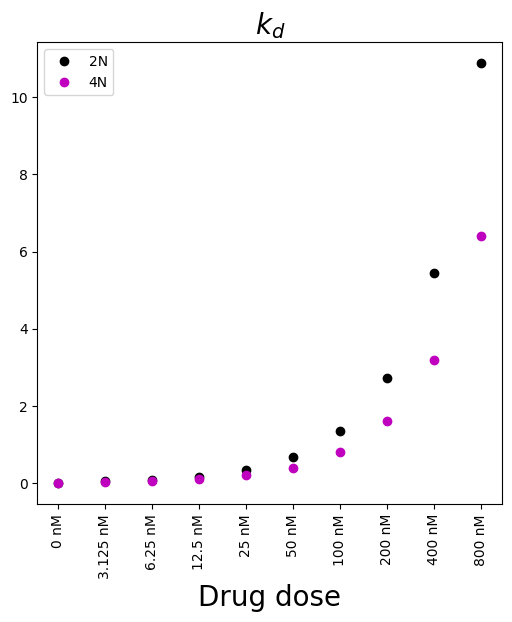

In [108]:
# Calculate the mean and standard deviation for each column
fig, ((ax0)) = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(6, 6))

means1 = np.mean(kd_2N, axis=0)
std_devs1 = np.std(kd_2N, axis=0)

# means11 = np.mean(fg_2N_ic, axis=0)
# std_devs11 = np.std(fg_2N_ic, axis=0)

means2 = np.mean(kd_4N, axis=0)
std_devs2 = np.std(kd_4N, axis=0)

my_xlabels = ['0 nM', '3.125 nM', '6.25 nM', '12.5 nM', '25 nM', '50 nM', '100 nM', '200 nM', '400 nM', '800 nM']
    
# Generate a plot with error bars
x = np.arange(1, 11)  # X-axis points for each column

ax0.set_title(r"$k_d$",fontsize = 20)
ax0.plot(x,  kd_2N, 'ko', label='2N')
ax0.plot(x,  kd_4N, 'mo', label='4N')
ax0.legend()
ax0.set_xticks(x, my_xlabels, rotation ='vertical')
ax0.set_xlabel("Drug dose",fontsize = 20)


# ax1.set_title(r"$f_g$",fontsize = 20)
# ax1.plot(x,  fg_2N_ic, 'ko', label='2N, using IC50')
# ax1.plot(x,  fg_4N_ic, 'mo', label='4N, using IC50')
# ax1.legend()
# ax1.set_xticks(x, my_xlabels, rotation ='vertical')
# ax1.set_xlabel("Drug dose",fontsize = 20)




plt.show()